# Baseline vs Ablations: Check Impact Analysis

This notebook analyzes the baseline experiment results against ablation runs where certain checks were disabled. It focuses on how the outcome of the same experiments changed when the following checks were turned off:

- no_lint
- no_tests
- no_playwright

Data sources are CSV files in `analysis/` with a common schema:
- Case identifier and Assignee
- AB-xx check columns with values in {PASS, WARN, FAIL, NA}
- Aggregate columns: `PASS#`, `WARN#`, `FAIL#`, `PTS`
- Free-text `Notes`

We will:
- Load and clean the datasets
- Summarize the baseline
- Compare each ablation to baseline with per-case deltas and aggregate trends
- Visualize mean deltas and surface the largest regressions and improvements


In [7]:
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_colwidth", 200)

DATA_DIR = Path("/home/eugenek/app.build-neurips25/analysis")
FILES = {
    "baseline": DATA_DIR / "app.build-neurips25 - baseline.csv",
    "no_lint": DATA_DIR / "app.build-neurips25 - ablations_no_lint.csv",
    "no_playwright": DATA_DIR / "app.build-neurips25 - ablations_no_playwright.csv",
    "no_tests": DATA_DIR / "app.build-neurips25 - ablations_no_tests.csv",
}

AB_COLUMNS = [
    "AB-01 Boot",
    "AB-02 Prompt",
    "AB-03 Create",
    "AB-04 View/Edit",
    "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75",
]

AGG_COLUMNS = ["PASS#", "WARN#", "FAIL#", "PTS"]
KEY_COLUMN = "Case"

STATUS_ORDER = ["FAIL", "WARN", "NA", "PASS"]  # ordered for ordinal mapping
STATUS_TO_SCORE = {"FAIL": 0, "WARN": 0.5, "NA": np.nan, "PASS": 1.0}


def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # unify column names (strip spaces) and types
    df.columns = [c.strip() for c in df.columns]
    # ensure numeric columns are numeric
    for col in AGG_COLUMNS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    # ensure PTS exists; if missing set NaN
    if "PTS" not in df.columns:
        df["PTS"] = np.nan
    # key normalization
    df[KEY_COLUMN] = df[KEY_COLUMN].astype(str)
    return df


def score_status_columns(df: pd.DataFrame) -> pd.DataFrame:
    scored = df.copy()
    for col in AB_COLUMNS:
        if col in scored.columns:
            scored[f"{col}__score"] = scored[col].map(STATUS_TO_SCORE)
        else:
            scored[f"{col}__score"] = np.nan
    scored["AB_mean_score"] = scored[[f"{c}__score" for c in AB_COLUMNS]].mean(axis=1, skipna=True)
    return scored


# Load all datasets
raw: Dict[str, pd.DataFrame] = {k: load_csv(v) for k, v in FILES.items()}
scored: Dict[str, pd.DataFrame] = {k: score_status_columns(df) for k, df in raw.items()}

# Align on common cases present in baseline for fair comparison
baseline_cases = set(scored["baseline"][KEY_COLUMN])
for k in list(scored.keys()):
    scored[k] = scored[k][scored[k][KEY_COLUMN].isin(baseline_cases)].reset_index(drop=True)

len(baseline_cases), {k: len(v) for k, v in scored.items()}


(30, {'baseline': 30, 'no_lint': 30, 'no_playwright': 30, 'no_tests': 30})

In [ ]:
# Recalculate PTS per custom formula for all tables

WEIGHTS = {
    "AB-01 Boot": (0.10, 0.08),
    "AB-02 Prompt": (0.50, 0.40),
    "AB-03 Create": (0.10, 0.05),
    "AB-04 View/Edit": (0.10, 0.05),
    "AB‑06 Clickable Sweep": (0.10, 0.05),
    "AB‑07 Performance >75": (0.10, 0.05),
}

GATE_FAIL_COLUMNS = ["AB-01 Boot", "AB-02 Prompt"]


def _cell_score(value: str, pass_w: float, warn_w: float) -> float:
    if value == "PASS":
        return pass_w
    if value == "WARN":
        return warn_w
    return 0.0


def recalc_pts(df: pd.DataFrame) -> pd.Series:
    def compute_row(row: pd.Series) -> float:
        # If either Boot or Prompt is FAIL => 0
        for col in GATE_FAIL_COLUMNS:
            if col in row and str(row[col]) == "FAIL":
                return 0.0
        total = 0.0
        for col, (pw, ww) in WEIGHTS.items():
            val = str(row.get(col, ""))
            total += _cell_score(val, pw, ww)
        return total * 10.0

    return df.apply(compute_row, axis=1)

# Apply to all datasets and overwrite PTS
for k in list(scored.keys()):
    scored[k]["PTS"] = recalc_pts(scored[k])

# Quick sanity: show mean PTS per table
{k: float(scored[k]["PTS"].mean()) for k in scored}


In [8]:
# Baseline summary
base = scored["baseline"].copy()

# Aggregate means
baseline_agg = base[AGG_COLUMNS + ["AB_mean_score", "PTS"]].mean(numeric_only=True).to_frame("mean").T
# Status counts per AB column
status_counts = {}
for col in AB_COLUMNS:
    if col in base.columns:
        status_counts[col] = base[col].value_counts().reindex(STATUS_ORDER).fillna(0).astype(int)
status_counts_df = pd.DataFrame(status_counts).T

print("Baseline aggregate means (PASS#/WARN#/FAIL#/PTS, AB_mean_score):")
baseline_agg


Baseline aggregate means (PASS#/WARN#/FAIL#/PTS, AB_mean_score):


,PASS#,WARN#,FAIL#,PTS,AB_mean_score,PTS
mean,4.266667,0.466667,0.333333,6.61,0.805833,6.61


In [9]:
# Compute deltas vs baseline for each ablation

def compute_deltas_vs_baseline(baseline: pd.DataFrame, variant: pd.DataFrame, label: str) -> pd.DataFrame:
    b = baseline[[KEY_COLUMN, "AB_mean_score", "PTS"] + [f"{c}__score" for c in AB_COLUMNS]].copy()
    v = variant[[KEY_COLUMN, "AB_mean_score", "PTS"] + [f"{c}__score" for c in AB_COLUMNS]].copy()
    merged = b.merge(v, on=KEY_COLUMN, suffixes=("_base", f"_{label}"))

    # Per-case deltas
    merged[f"delta_AB_mean_score_{label}"] = merged[f"AB_mean_score_{label}"] - merged["AB_mean_score_base"]
    merged[f"delta_PTS_{label}"] = merged[f"PTS_{label}"] - merged["PTS_base"]
    for c in AB_COLUMNS:
        merged[f"delta_{c}__score_{label}"] = merged[f"{c}__score_{label}"] - merged[f"{c}__score_base"]

    return merged


deltas = {}
base_df = scored["baseline"].copy()
for label in ["no_lint", "no_tests", "no_playwright"]:
    deltas[label] = compute_deltas_vs_baseline(base_df, scored[label], label)

# Aggregate mean deltas per ablation
mean_deltas = []
for label, df in deltas.items():
    row = {
        "ablation": label,
        "mean_delta_AB_mean_score": df[f"delta_AB_mean_score_{label}"].mean(),
        "mean_delta_PTS": df[f"delta_PTS_{label}"].mean(),
    }
    for c in AB_COLUMNS:
        row[f"mean_delta_{c}__score"] = df[f"delta_{c}__score_{label}"].mean()
    mean_deltas.append(row)

mean_deltas_df = pd.DataFrame(mean_deltas)
mean_deltas_df


,ablation,mean_delta_AB_mean_score,mean_delta_PTS,mean_delta_AB-01 Boot__score,mean_delta_AB-02 Prompt__score,mean_delta_AB-03 Create__score,mean_delta_AB-04 View/Edit__score,mean_delta_AB‑06 Clickable Sweep__score,mean_delta_AB‑07 Performance >75__score
0,no_lint,0.019444,-0.076667,0.033333,0.076923,-0.045455,-0.041667,0.000000,0.020000
1,no_tests,-0.026667,0.766667,-0.016667,0.108696,-0.052632,-0.200000,0.095238,-0.045455
2,no_playwright,0.056111,1.383333,0.016667,0.096154,-0.020833,0.033333,0.000000,0.000000


/tmp/ipykernel_640256/3060668029.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_AB_mean_score", ax=axes[0], palette="Set2")
/tmp/ipykernel_640256/3060668029.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_PTS", ax=axes[1], palette="Set2")


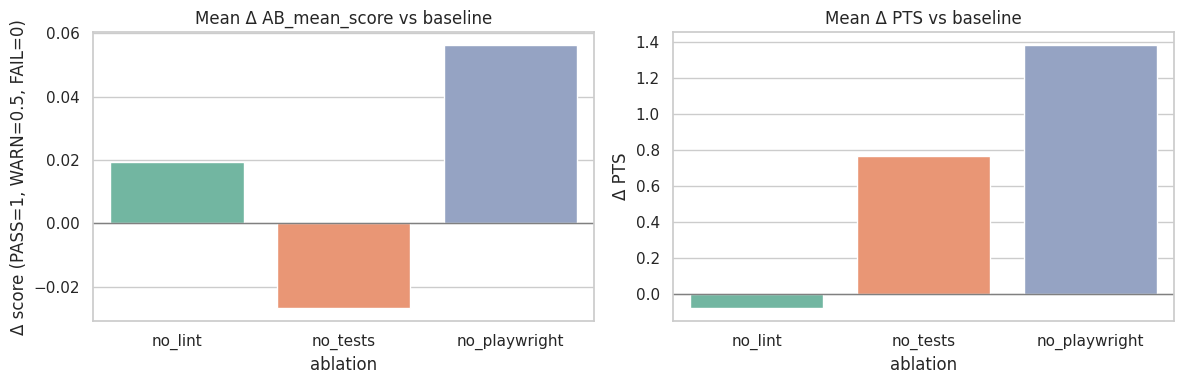

,ablation
0,no_lint


,Case,delta_AB_mean_score,ablation
4,bookmark-management-app_trpc-agent_claude_gemini,-0.750,no_lint
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-0.400,no_lint
2,birthday-wish-app_trpc-agent_claude_gemini,-0.375,no_lint
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-0.200,no_lint
24,recipe-sharing-platform_trpc-agent_claude_gemini,-0.200,no_lint


,Case,delta_PTS,ablation
24,recipe-sharing-platform_trpc-agent_claude_gemini,-9.0,no_lint
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-9.0,no_lint
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-8.5,no_lint
2,birthday-wish-app_trpc-agent_claude_gemini,-7.8,no_lint
8,currency-converter_trpc-agent_claude_gemini,-2.0,no_lint


,ablation
0,no_tests


,Case,delta_AB_mean_score,ablation
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-1.000000,no_tests
18,pastel-blue-notes-app_trpc-agent_claude_gemini,-0.916667,no_tests
28,todo-list-with-mood_trpc-agent_claude_gemini,-0.916667,no_tests
4,bookmark-management-app_trpc-agent_claude_gemini,-0.750000,no_tests
24,recipe-sharing-platform_trpc-agent_claude_gemini,-0.583333,no_tests


,Case,delta_PTS,ablation
28,todo-list-with-mood_trpc-agent_claude_gemini,-9.5,no_tests
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-9.0,no_tests
18,pastel-blue-notes-app_trpc-agent_claude_gemini,-9.0,no_tests
24,recipe-sharing-platform_trpc-agent_claude_gemini,-9.0,no_tests
15,indonesian-inventory-app_trpc-agent_claude_gemini,-1.5,no_tests


,ablation
0,no_playwright


,Case,delta_AB_mean_score,ablation
2,birthday-wish-app_trpc-agent_claude_gemini,-0.500000,no_playwright
12,gym-crm_trpc-agent_claude_gemini,-0.500000,no_playwright
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-0.300000,no_playwright
27,tennis-enthusiast-platform_trpc-agent_claude_gemini,-0.166667,no_playwright
4,bookmark-management-app_trpc-agent_claude_gemini,-0.150000,no_playwright


,Case,delta_PTS,ablation
22,plumbing-business-landing-page_trpc-agent_claude_gemini,-8.5,no_playwright
2,birthday-wish-app_trpc-agent_claude_gemini,-7.8,no_playwright
10,engineering-job-board_trpc-agent_claude_gemini,-1.5,no_playwright
8,currency-converter_trpc-agent_claude_gemini,-1.0,no_playwright
6,cat-conspiracy-tracker_trpc-agent_claude_gemini,-1.0,no_playwright


In [10]:
# Visualization: mean deltas and worst-case drops
sns.set_theme(style="whitegrid")

# Barplot of mean delta AB_mean_score and PTS
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_AB_mean_score", ax=axes[0], palette="Set2")
axes[0].axhline(0, color="gray", linewidth=1)
axes[0].set_title("Mean Δ AB_mean_score vs baseline")
axes[0].set_ylabel("Δ score (PASS=1, WARN=0.5, FAIL=0)")

sns.barplot(data=mean_deltas_df, x="ablation", y="mean_delta_PTS", ax=axes[1], palette="Set2")
axes[1].axhline(0, color="gray", linewidth=1)
axes[1].set_title("Mean Δ PTS vs baseline")
axes[1].set_ylabel("Δ PTS")
plt.tight_layout()
plt.show()

# Identify worst-case drops per ablation by AB_mean_score and PTS
worst_rows = []
for label, df in deltas.items():
    row_score = df.sort_values(f"delta_AB_mean_score_{label}").head(5)[[KEY_COLUMN, f"delta_AB_mean_score_{label}"]]
    row_score["ablation"] = label
    row_pts = df.sort_values(f"delta_PTS_{label}").head(5)[[KEY_COLUMN, f"delta_PTS_{label}"]]
    row_pts["ablation"] = label
    worst_rows.append((label, row_score, row_pts))

# Show top 5 worst Δ by AB_mean_score and PTS for each ablation
for label, w_score, w_pts in worst_rows:
    display(pd.DataFrame({"ablation": [label]}))
    display(w_score.rename(columns={f"delta_AB_mean_score_{label}": "delta_AB_mean_score"}))
    display(w_pts.rename(columns={f"delta_PTS_{label}": "delta_PTS"}))


In [11]:
# Overall PTS impact per ablation

overall_impact_rows = []
change_breakdowns = []

for label, df in deltas.items():
    pts_delta = df[f"delta_PTS_{label}"]
    overall_impact_rows.append({
        "ablation": label,
        "total_delta_PTS": pts_delta.sum(skipna=True),
        "mean_delta_PTS": pts_delta.mean(skipna=True),
        "median_delta_PTS": pts_delta.median(skipna=True),
        "num_improved": int((pts_delta > 0).sum()),
        "num_unchanged": int((pts_delta == 0).sum()),
        "num_regressed": int((pts_delta < 0).sum()),
    })
    change_breakdowns.append(
        pd.DataFrame({
            "ablation": label,
            "delta_PTS": pts_delta,
        })
    )

pts_impact_df = pd.DataFrame(overall_impact_rows).sort_values("ablation")
pts_impact_df


,ablation,total_delta_PTS,mean_delta_PTS,median_delta_PTS,num_improved,num_unchanged,num_regressed
0,no_lint,-2.3,-0.076667,0.0,8,11,11
2,no_playwright,41.5,1.383333,0.0,13,11,6
1,no_tests,23.0,0.766667,0.0,13,7,10


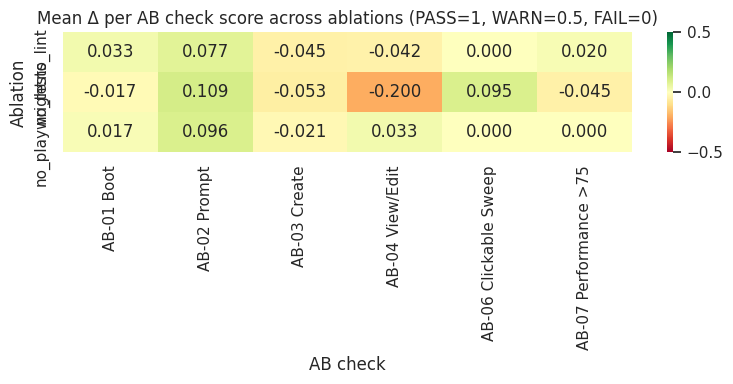


=== Status transitions for no_lint ===


,AB
0,AB-01 Boot


AB-01 Boot_no_lint,FAIL,WARN,NA,PASS
AB-01 Boot_base,,,,
FAIL,1,0,0,2
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,1,0,23


,baseline,variant,count
3,FAIL,PASS,2
7,WARN,PASS,1
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-02 Prompt


AB-02 Prompt_no_lint,FAIL,WARN,NA,PASS
AB-02 Prompt_base,,,,
FAIL,1,1,0,3
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,2,0,16


,baseline,variant,count
3,FAIL,PASS,3
13,PASS,WARN,2
1,FAIL,WARN,1
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB-03 Create


AB-03 Create_no_lint,FAIL,WARN,NA,PASS
AB-03 Create_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,2
NA,0,0,0,0
PASS,2,0,0,18


,baseline,variant,count
7,WARN,PASS,2
12,PASS,FAIL,2


,AB
0,AB-04 View/Edit


AB-04 View/Edit_no_lint,FAIL,WARN,NA,PASS
AB-04 View/Edit_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,0,2,0,9


,baseline,variant,count
13,PASS,WARN,2
7,WARN,PASS,1


,AB
0,AB‑06 Clickable Sweep


AB‑06 Clickable Sweep_no_lint,FAIL,WARN,NA,PASS
AB‑06 Clickable Sweep_base,,,,
FAIL,0,1,0,0
WARN,1,1,0,2
NA,0,0,0,0
PASS,0,2,0,16


,baseline,variant,count
13,PASS,WARN,2
7,WARN,PASS,2
4,WARN,FAIL,1
1,FAIL,WARN,1


,AB
0,AB‑07 Performance >75


AB‑07 Performance >75_no_lint,FAIL,WARN,NA,PASS
AB‑07 Performance >75_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,2
NA,0,0,0,0
PASS,0,1,0,22


,baseline,variant,count
7,WARN,PASS,2
13,PASS,WARN,1



=== Status transitions for no_tests ===


,AB
0,AB-01 Boot


AB-01 Boot_no_tests,FAIL,WARN,NA,PASS
AB-01 Boot_base,,,,
FAIL,0,0,0,3
WARN,0,1,0,1
NA,0,0,0,0
PASS,4,0,0,21


,baseline,variant,count
12,PASS,FAIL,4
3,FAIL,PASS,3
7,WARN,PASS,1


,AB
0,AB-02 Prompt


AB-02 Prompt_no_tests,FAIL,WARN,NA,PASS
AB-02 Prompt_base,,,,
FAIL,0,3,0,2
WARN,0,0,0,1
NA,0,0,0,0
PASS,1,1,0,15


,baseline,variant,count
1,FAIL,WARN,3
3,FAIL,PASS,2
7,WARN,PASS,1
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-03 Create


AB-03 Create_no_tests,FAIL,WARN,NA,PASS
AB-03 Create_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,1,1,0,16


,baseline,variant,count
7,WARN,PASS,1
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-04 View/Edit


AB-04 View/Edit_no_tests,FAIL,WARN,NA,PASS
AB-04 View/Edit_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,1,5,0,8


,baseline,variant,count
13,PASS,WARN,5
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB‑06 Clickable Sweep


AB‑06 Clickable Sweep_no_tests,FAIL,WARN,NA,PASS
AB‑06 Clickable Sweep_base,,,,
FAIL,0,1,0,0
WARN,0,1,0,3
NA,0,0,0,0
PASS,0,0,0,16


,baseline,variant,count
7,WARN,PASS,3
1,FAIL,WARN,1


,AB
0,AB‑07 Performance >75


AB‑07 Performance >75_no_tests,FAIL,WARN,NA,PASS
AB‑07 Performance >75_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,0,3,0,18


,baseline,variant,count
13,PASS,WARN,3
7,WARN,PASS,1



=== Status transitions for no_playwright ===


,AB
0,AB-01 Boot


AB-01 Boot_no_playwright,FAIL,WARN,NA,PASS
AB-01 Boot_base,,,,
FAIL,1,0,0,2
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,2,0,22


,baseline,variant,count
3,FAIL,PASS,2
13,PASS,WARN,2
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB-02 Prompt


AB-02 Prompt_no_playwright,FAIL,WARN,NA,PASS
AB-02 Prompt_base,,,,
FAIL,0,2,0,2
WARN,0,1,0,2
NA,0,0,0,0
PASS,1,1,0,17


,baseline,variant,count
1,FAIL,WARN,2
3,FAIL,PASS,2
7,WARN,PASS,2
12,PASS,FAIL,1
13,PASS,WARN,1


,AB
0,AB-03 Create


AB-03 Create_no_playwright,FAIL,WARN,NA,PASS
AB-03 Create_base,,,,
FAIL,0,0,0,0
WARN,0,1,0,1
NA,0,0,0,0
PASS,1,0,0,21


,baseline,variant,count
7,WARN,PASS,1
12,PASS,FAIL,1


,AB
0,AB-04 View/Edit


AB-04 View/Edit_no_playwright,FAIL,WARN,NA,PASS
AB-04 View/Edit_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,1
NA,0,0,0,0
PASS,0,0,0,14


,baseline,variant,count
7,WARN,PASS,1


,AB
0,AB‑06 Clickable Sweep


AB‑06 Clickable Sweep_no_playwright,FAIL,WARN,NA,PASS
AB‑06 Clickable Sweep_base,,,,
FAIL,0,0,0,1
WARN,1,0,0,3
NA,0,0,0,0
PASS,1,2,0,17


,baseline,variant,count
7,WARN,PASS,3
13,PASS,WARN,2
3,FAIL,PASS,1
4,WARN,FAIL,1
12,PASS,FAIL,1


,AB
0,AB‑07 Performance >75


AB‑07 Performance >75_no_playwright,FAIL,WARN,NA,PASS
AB‑07 Performance >75_base,,,,
FAIL,0,0,0,0
WARN,0,0,0,2
NA,0,0,0,0
PASS,1,0,0,23


,baseline,variant,count
7,WARN,PASS,2
12,PASS,FAIL,1


In [12]:
# Per-AB score analysis across ablations

# Build a long-form table of mean deltas per AB column and ablation
ab_mean_delta_rows = []
for label, df in deltas.items():
    row = {"ablation": label}
    for c in AB_COLUMNS:
        row[c] = df[f"delta_{c}__score_{label}"].mean()
    ab_mean_delta_rows.append(row)

ab_mean_delta_df = pd.DataFrame(ab_mean_delta_rows).set_index("ablation")[AB_COLUMNS]

# Heatmap of mean delta scores per AB
plt.figure(figsize=(8, 4))
sns.heatmap(ab_mean_delta_df, annot=True, fmt=".3f", center=0, cmap="RdYlGn", vmin=-0.5, vmax=0.5)
plt.title("Mean Δ per AB check score across ablations (PASS=1, WARN=0.5, FAIL=0)")
plt.ylabel("Ablation")
plt.xlabel("AB check")
plt.tight_layout()
plt.show()

# Transition counts: how statuses change from baseline to each ablation per AB
# We will compute a cross-tab for each AB and ablation and display top transitions
from itertools import product

TRANSITIONS_TO_SHOW = 8

for label in ["no_lint", "no_tests", "no_playwright"]:
    print(f"\n=== Status transitions for {label} ===")
    merged = scored["baseline"][[KEY_COLUMN] + AB_COLUMNS].merge(
        scored[label][[KEY_COLUMN] + AB_COLUMNS], on=KEY_COLUMN, suffixes=("_base", f"_{label}")
    )
    for c in AB_COLUMNS:
        base_s = merged[f"{c}_base"].astype(str)
        var_s = merged[f"{c}_{label}"].astype(str)
        ct = pd.crosstab(base_s, var_s).reindex(index=STATUS_ORDER, columns=STATUS_ORDER, fill_value=0)
        display(pd.DataFrame({"AB": [c]}))
        display(ct)
        # Flatten and show top transitions by count excluding unchanged PASS->PASS, WARN->WARN, FAIL->FAIL, NA->NA
        flattened = ct.stack().rename_axis(index=["baseline", "variant"]).reset_index(name="count")
        flattened = flattened[(flattened["baseline"] != flattened["variant"]) & (flattened["count"] > 0)]
        display(flattened.sort_values("count", ascending=False).head(TRANSITIONS_TO_SHOW))
